In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

In [13]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
DDoS=pd.read_csv('/content/dataset_sdn.csv')

In [5]:
#Transformations of categorical features
DDoS['Protocol'] = DDoS['Protocol'].astype('category')
DDoS['src'] = DDoS['src'].astype('category')
DDoS['dst'] = DDoS['dst'].astype('category')

cat_columns = DDoS.select_dtypes(['category']).columns
DDoS[cat_columns] = DDoS[cat_columns].apply(lambda x: x.cat.codes)

In [6]:
DDoS["rx_kbps"] = DDoS["rx_kbps"].fillna(DDoS["rx_kbps"].mean())

In [7]:
DDoS["tot_kbps"] = DDoS["tot_kbps"].fillna(DDoS["tot_kbps"].mean())

In [8]:
from sklearn.model_selection import train_test_split
X = DDoS[['src','dst','dt', 'switch', 'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow','Protocol' ,'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps']]
y = DDoS['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [9]:
# Feature scaling (or standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# reshape inputs for LSTM [samples, timesteps, features]


X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (62607, 1, 22)
Test data shape: (41738, 1, 22)


In [14]:
def create_baseline():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(22, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(64, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax', kernel_regularizer='l2'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [15]:
model = create_baseline()

In [16]:
history = model.fit(X_train, y_train, epochs = 10,validation_split=0.2,verbose = 1)

Epoch 1/10
1566/1566 [==============================] - 10s 4ms/step - loss: 0.5252 - accuracy: 0.8866 - val_loss: 0.3797 - val_accuracy: 0.9330
Epoch 2/10
1566/1566 [==============================] - 5s 3ms/step - loss: 0.3724 - accuracy: 0.9368 - val_loss: 0.3542 - val_accuracy: 0.9416
Epoch 3/10
1566/1566 [==============================] - 5s 3ms/step - loss: 0.3551 - accuracy: 0.9405 - val_loss: 0.3428 - val_accuracy: 0.9443
Epoch 4/10
1566/1566 [==============================] - 5s 3ms/step - loss: 0.3466 - accuracy: 0.9412 - val_loss: 0.3357 - val_accuracy: 0.9457
Epoch 5/10
1566/1566 [==============================] - 5s 3ms/step - loss: 0.3397 - accuracy: 0.9425 - val_loss: 0.3292 - val_accuracy: 0.9436
Epoch 6/10
1566/1566 [==============================] - 6s 4ms/step - loss: 0.3316 - accuracy: 0.9439 - val_loss: 0.3239 - val_accuracy: 0.9459
Epoch 7/10
1566/1566 [==============================] - 5s 3ms/step - loss: 0.3276 - accuracy: 0.9438 - val_loss: 0.3176 - val_accuracy

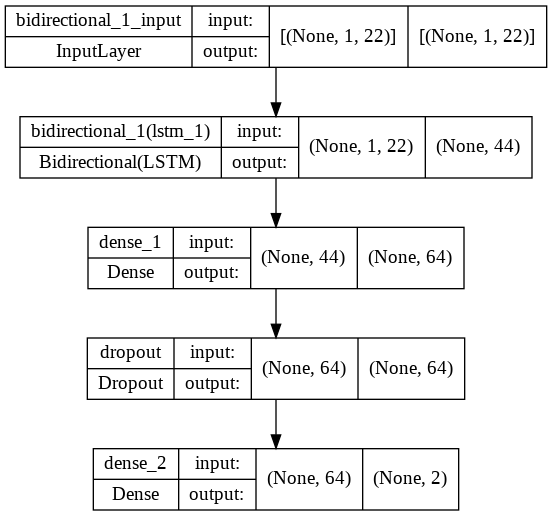

In [17]:
from tensorflow import keras
keras.utils.plot_model(model,show_shapes=True)

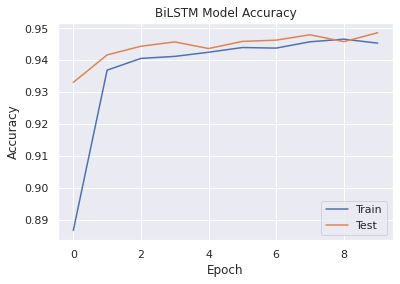

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BiLSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BiLSTM Model Accuracy.png')
plt.show()

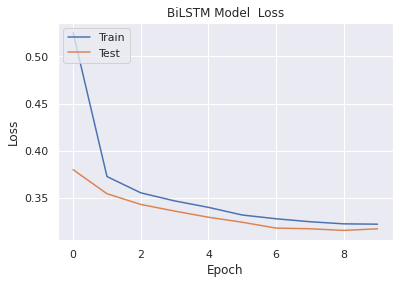

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BiLSTM Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BiLSTM Model Loss.png')
plt.show()

In [20]:
predict = model.predict(X_test, verbose=1)

1305/1305 [==============================] - 3s 2ms/step


In [21]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1

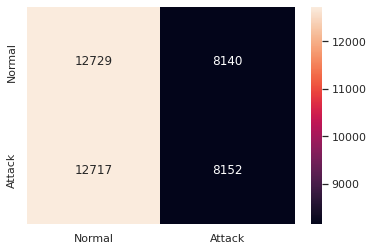

In [22]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Normal","Attack"],columns = ["Normal","Attack"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [23]:
figure = ax.get_figure()    
figure.savefig('confusion_matrix_BiLSTM.png', dpi=400)

In [24]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 95.09%
